In [2]:
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from math import *
from tqdm import tqdm
from Aero_info import table_atm
from Interpolation import Interp1d, Interp2d, InterpVec

In [3]:
opts = {
    'm_0': 2402.896642527979,
    'd': 0.515,
    't_marsh': 11.602913766241713,
    'w_marsh': 1417.7090190915076,
    'P_marsh': 329901.12903225806,
    'I': 2700,
    'r_kill': 50,
    'alpha_max': 20,
    'speed_change_alpha': 86,
    'xi': 0.1,
    'V_0': 25,
    'Q_0': 75,
    'am': 5,
    'dny': 1
}

In [37]:
class Missile(object):
    
    def __init__(self, **kwargs):
        """
        Конструктор класса Missile:
         dny        -- запас по перегрузке
         am         -- коэф-т, характеризующий быстроту реакции ракеты на манёвр цели
         m_itr      -- масса [кг] ракеты от времени [с]
         P_itr      -- тяга [Н] ракеты от времени [с]
         S_m        -- площадь миделя [м^2] (к которой относятся АД коэффициенты)
         alpha_max  -- максимальный угол атаки [градусы]
         speed_change_alpha -- скорость изменения угола атаки [градусы / с]
         xi         -- коэффициент, характеризующий структуру подъёмной силы аэродинамической схемы ракеты
         Cx_itr     -- интерполятор определения коэффициента лобового сопротивления ракеты
                       от угла атаки [градусы] и от числа маха 
         atm_itr    -- интерполятор параметров атмосферы
        """
        self.dt   = kwargs['dt']
        self.g    = kwargs['g']
        self.V_0  = kwargs['V_0']
        self.x_0  = kwargs['x_0']
        self.y_0  = kwargs['y_0']
        self.Q_0  = kwargs['Q_0']
        self.t_0  = kwargs['t_0']
        self.am   = kwargs['am']
        self.dny  = kwargs['dny']
        self.S_m  = kwargs['S_m']
        self.xi   = kwargs['xi']
        self.P_itr   = kwargs['P_itr']
        self.m_itr   = kwargs['m_itr']
        self.Cx_itr  = kwargs['Cx_itr']
        self.atm_itr = kwargs['atm_itr']
        self.Cya_itr = kwargs['Cya_itr']
        self.r_kill  = kwargs['r_kill']
        self.alpha_0 = kwargs['alpha_0']
        self.alpha_max          = kwargs['alpha_max']
        self.speed_change_alpha = kwargs['speed_change_alpha']
        self.alpha_targeting    = 0        

    @classmethod
    def get_missile(cls, dict_opts):
        """
        Классовый метод создания стандартной ракеты со всеми необходимыми аэродинамическими, массо-
        и тяговременными характеристиками
        arguments: dict_opts {dict} -- словарь с параметрами проектируемой ракеты
        returns:   экземпляр класса Missile {cls}
        """
        
        @np.vectorize
        def get_m(t):
            if t < t_marsh:
                return m_0 - G_marsh * t
            else:
                return m_0 - w_marsh
            
        @np.vectorize
        def get_P(t):
            if t < t_marsh:
                return P_marsh
            else:
                return 0
        
        dt      = dict_opts.get('dt', 0.001)
        g       = dict_opts.get('g', 9.80665)
        V_0     = dict_opts.get('V_0', 0)
        x_0     = dict_opts.get('x_0', 0)
        y_0     = dict_opts.get('y_0', 0)
        Q_0     = dict_opts.get('Q_0', 0)
        alpha_0 = dict_opts.get('alpha_0', 0)
        t_0     = dict_opts.get('t_0', 0)
        am      = dict_opts.get('am')
        dny     = dict_opts.get('dny', 1)
        d       = dict_opts.get('d')
        m_0     = dict_opts.get('m_0')
        t_marsh = dict_opts.get('t_marsh')
        w_marsh = dict_opts.get('w_marsh')
        P_marsh = dict_opts.get('P_marsh')
        I       = dict_opts.get('I')
        r_kill  = dict_opts.get('r_kill')
        xi      = dict_opts.get('xi')
        alpha_max = dict_opts.get('alpha_max')
        speed_change_alpha = dict_opts.get('speed_change_alpha')
        
        S_mid   = np.pi * d ** 2 / 4
        G_marsh = w_marsh / t_marsh
          
        ts    = np.linspace(0, t_marsh, 100)
        m_itr = Interp1d(ts, get_m(ts))
        P_itr = Interp1d(ts, get_P(ts))
        
        df1 = pd.read_csv('cya_from_mach.csv', sep = ";")
        df2 = pd.read_csv('cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
        arr_alpha = np.array(df2.index)
        arr_mach = df1['Mach']
        arr_cya = df1['Cya']
        arr_cx = df2.to_numpy()

        Cx_itr  = Interp2d(arr_alpha, arr_mach, arr_cx)
        Cya_itr = Interp1d(arr_mach, arr_cya)

        missile = cls(
            dt       = dt,
            g        = g,
            V_0      = V_0,
            x_0      = x_0,
            y_0      = y_0,
            Q_0      = Q_0,
            t_0      = t_0,
            am       = am,
            dny      = dny,
            S_m      = S_mid,
            alpha_0  = alpha_0,
            m_itr    = m_itr,
            P_itr    = P_itr,
            alpha_max = alpha_max,
            speed_change_alpha = speed_change_alpha,
            xi       = xi,  
            Cx_itr   = Cx_itr,
            atm_itr  = table_atm,
            Cya_itr  = Cya_itr,
            r_kill   = r_kill
        )
        return missile

    def get_standart_parameters_of_missile(self):
        """
        Возвращает стандартное начальное состояние ракеты
        returns: {np.ndarray} -- [v,   x, y,       Q,   alpha, t]
                                 [м/с, м, м, радианы, градусы, с]
        """
        return np.array([self.V_0, self.x_0, self.y_0, np.radians(self.Q_0), self.alpha_0, self.t_0])     
        
    def set_init_cond(self, parameters_of_missile=None):
        """
        Задает начальные параметры (положение, скорость, углы ...) и запоминает их для того,
        чтобы потом в них можно было вернуться при помощи reset()
        arguments: parameters_of_missile 
        """
        if parameters_of_missile is None:
            parameters_of_missile = self.get_standart_parameters_of_missile()
        self.state   = np.array(parameters_of_missile)
        self.state_0 = np.array(parameters_of_missile)

    def reset(self):
        """
        Возвращает ракету в начальное состояние
        """
        self.set_state(self.state_0)

    def get_state(self):
        """
        Метод получения вектора со всеми параметрами системы 
        (схож с вектором 'y' при интегрировании ode, но в векторе state еще должно быть t)
        returns: {np.ndarray} -- [v,   x, y, Q,       alpha,   t]
                                 [м/с, м, м, радианы, градусы, с]
        """
        return self.state
    
    def get_state_0(self):
        return self.state_0

    def set_state(self, state):
        """
        Метод задания нового (может полностью отличающегося от текущего) состояния ракеты
        arguments: state {np.ndarray} -- [v,   x, y, Q,       alpha,   t]
                                         [м/с, м, м, радианы, градусы, с]
        """
        self.state = np.array(state)

    @property
    def action_space(self):
        """
        Возвращает int'овый numpy-массив, элементы которого являются возможными действиями агента
        """
        return np.array([-1, 0, 1])

    def action_sample(self):
        """
        Возвращает случайное возможное действие (int)
        """
        return rd.randint(-1, 1)

    @property
    def pos(self):
        """
        Свойство, возвращающее текущее положение ц.м. ракеты в виде numpy массива из двух элементов 
        np.array([x,y])
        """
        return np.array([self.state[1], self.state[2]])

    @property
    def vel(self):
        """
        Свойство, возвращающее текущий вектор скорости ракеты в виде numpy массива из двух элементов 
        np.array([Vx, Vy])
        """
        v = self.state[0]
        Q = self.state[3]
        return np.array([v * np.cos(Q), v * np.sin(Q)])

    @property
    def x_axis(self):
        """
        Свойство, возвращающее текущий нормированный вектор центральной оси ракеты в виде numpy массива из двух элементов 
        np.array([Axi_x, Axi_y])
        """
        Q = self.Q
        alpha = np.radians(self.alpha)
        return np.array([np.cos(Q  + alpha), np.sin(Q + alpha)])

    @property
    def v(self):
        return self.state[0]

    @property
    def x(self):
        return self.state[1]

    @property
    def y(self):
        return self.state[2]

    @property
    def Q(self):
        return self.state[3]

    @property
    def alpha(self):
        return self.state[4]
    
    @property
    def t(self):
        return self.state[5]

    @property
    def M(self):
        return self.v / self.atm_itr(self.y, 4)

    @property
    def Cya(self):
        return self.Cya_itr(self.M)  

    @property
    def Cx(self):
        return self.Cx_itr(self.alpha, self.M)       
        
    def f_system(self, t, y):
        """
        Функция правой части системы ОДУ динамики ракеты
        arguments: t {float}      -- время
                   y {np.ndarray} -- вектор состояния системы 
                                 [v,   x, y, Q,       alpha   ]
                                 [м/с, м, м, радианы, градусы ]                        
        returns: {np.ndarray} -- dy/dt
                                 [dv,    dx,  dy,  dQ,        dalpha   ]
                                 [м/с^2, м/c, м/c, радианы/c, градусы/c]
        """
        v, x, y, Q, alpha = y
        P   = self.P_itr(t)
        m   = self.m_itr(t)
        ro  = self.atm_itr(y, 3)
        a   = self.atm_itr(y, 4)
        M   = v / a
        Cya = self.Cya_itr(M) 
        Cx  = self.Cx_itr(alpha, M)

        alpha_diff = self.alpha_targeting - alpha
        dalpha = 0                       if abs(alpha_diff) < 1e-6 else \
                 self.speed_change_alpha if alpha_diff > 0 else \
                -self.speed_change_alpha  

        return np.array([
            (P * np.cos(np.radians(alpha)) - ro * v ** 2 / 2 * self.S_m * Cx - m * self.g * np.sin(Q)) / m,
            v * np.cos(Q),
            v * np.sin(Q),
            (alpha * ( Cya * ro * v ** 2 / 2 * self.S_m * (1 + self.xi) + P / 57.3) / ( m * self.g ) - np.cos(Q)) * self.g / v,
            dalpha
            ], copy = False) 

    def validate_y(self, y):
        """
        Проверка значений углов вектора y
        """
        if y[4] > self.alpha_max:
            y[4] = self.alpha_max
        elif y[4] < -self.alpha_max:
            y[4] = -self.alpha_max
        elif abs(y[4] - self.alpha_targeting) < 1e-4:
            y[4] = self.alpha_targeting
            
        if y[3] < -180 or y[3] > 180:
            y[3] = y[3] % (2 * pi)
            y[3] = (y[3] + 2 * pi) % (2 * pi)
            if y[3] > pi:
                y[3] -= 2*pi
        return y

    def get_action_parallel_guidance(self, target):
        """
        Метод, возвращающий аналог action'a, соответствующий идельному методу параллельного сближения
        
        Arguments: target {object} -- ссылка на цель. Обязательно должен иметь два свойства: pos->np.ndarray и vel->np.ndarray. 
                                 Эти свойства аналогичны свойствам этого класса. 
                                 pos возвращает координату цели, vel -- скорость
        
        returns: {float}           -- [-1; 1] аналог action'a, только не int, а float. Если умножить его на self.alpha_max,
                                      то получится потребный угол атаки для обеспечения метода параллельного сближения
        """
        am  = self.am
        dny = self.dny

        xc, yc = target.pos
        Qc     = target.Q
        vc     = target.v
    
        v, x, y, Q, alpha, t = self.state
        P   = self.P_itr(t)
        m   = self.m_itr(t)
        ro  = self.atm_itr(y, 3)
        a   = self.atm_itr(y, 4)
        M   = v / a
        Cya = self.Cya_itr(M)

        vis = target.pos - self.pos
        fi  = np.arctan2(vis[1], vis[0])
        r   = np.linalg.norm(vis)
        
        vel_c_otn     = target.vel - self.vel
        vis1          = vis / r
        vel_c_otn_tau = vis1 * np.dot(vis1, vel_c_otn)
        vel_c_otn_n   = vel_c_otn - vel_c_otn_tau

        dfi_dt = copysign(np.linalg.norm(vel_c_otn_n)/r, np.cross(vis1, vel_c_otn_n))

        dQ_dt = am * dfi_dt
        nya = v * dQ_dt / self.g + np.cos(Q) + dny # потребная нормальная перегрузка
        alpha_req = (nya *  m * self.g) / (Cya * ro * v ** 2 / 2 * self.S_m * (1 + self.xi) + P / 57.3) # балансировочный угол атаки

        return alpha_req / self.alpha_max

    def get_action_chaise_guidance(self, target, t_corr=1/30, dny=1):
        """Метод, возвращающий аналог action'a, соответствующий идельному методу чистой погони
        
        Arguments:
            target {object} -- ссылка на цель. Обязательно должен иметь два свойства: pos->np.ndarray и vel->np.ndarray. 
                               Эти свойства аналогичны свойствам этого класса. pos возвращает координату цели, vel -- скорость
        
        returns {float} -- [-1; 1] аналог action'a, только не int, а float. Если умножить его на self.alphamax, то получится
                           потребный угол атаки для обеспечения метода параллельного сближения
        """

        xc, yc = target.pos
        Qc = target.Q
        vc = target.v

        v, x, y, Q, alpha, t = self.state
        P = self.P_itr(t)
        m = self.m_itr(t)
        ro  = self.atm_itr(y, 3)
        a   = self.atm_itr(y, 4)
        M = v/a
        Cya = self.Cya_itr(M)

        vis = target.pos + vc*t_corr - self.pos
        fi2 = np.arctan2(vis[1], vis[0])
        fi1 = Q

        dQ_dt = (fi2-fi1)/t_corr
        nya = v * dQ_dt / self.g + np.cos(Q) + dny
        alpha_req = (nya * m * self.g) / (Cya * ro * v ** 2 / 2 * self.S_m * (1 + self.xi) + P / 57.3)

        return alpha_req / self.alphamax
    
    def step(self, action, tau):
        """
        Моделирует динамику ракеты за шаг по времени tau. 
        На протяжении tau управляющее воздействие на ракету постоянно (action)
        Меняет внутреннее состояние ракеты на момент окончания шага
        arguments: action {int} -- управляющее воздействие на протяжении шага
                   tau {float}  -- длина шага по времени (не путать с шагом интегрирования)
        """
        self.alpha_targeting = self.alpha_max * action

        y = self.validate_y(self.state[:-1])
        t = self.state[-1]  
        t_end = t + tau

        flag = True
        while flag:
            if t_end - t > self.dt:
                dt = self.dt 
            else:
                dt = t_end - t
                flag = False
            k1 = self.f_system(t, y)
            k2 = self.f_system(t + 0.5 * dt, self.validate_y(y + 0.5 * dt * k1))
            k3 = self.f_system(t + 0.5 * dt, self.validate_y(y + 0.5 * dt * k2))
            k4 = self.f_system(t + dt, self.validate_y(y + dt * k3))
            t += dt
            y  = self.validate_y(y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
        self.set_state(np.append(y, t))
    
    def get_parameters_of_missile_to_meeting_target(self, trg_pos, trg_vel, missile_pos=None, missile_vel_abs=500.0):
        """
        Возвращает состояние ракеты, которая нацелена на мгновенную точку встречи с целью
        arguments:
            trg_vel {tuple/list/np.ndarray} -- вектор скорости цели
            trg_pos {tuple/list/np.ndarray} -- положение цели
        keyword arguments:
            my_pos {tuple/list/np.ndarray} -- начальное положение ракеты, если не указано, то (0,0) (default: {None})
            my_vel_abs {float} -- средняя скорость ракеты (default: {500})
        returns:
            [np.ndarray] -- [v, x, y, Q, alpha, t]
        """
        trg_vel = np.array(trg_vel)
        trg_pos = np.array(trg_pos)
        missile_pos = np.array(missile_pos) if missile_pos else np.array([0, 0])
        suc, meeting_point = self.get_instant_meeting_point(trg_pos, trg_vel, missile_vel_abs, missile_pos)
        vis = meeting_point - missile_pos
        Q = np.arctan2(vis[1], vis[0])
        return np.array([self.V_0, missile_pos[0], missile_pos[1], Q, self.alpha_0, self.t_0])
    
    def get_instant_meeting_point(trg_pos, trg_vel, my_vel_abs, my_pos):
        """
        Метод нахождения мгновенной точки встречи ракеты с целью (с координатой trg_pos и скоростью trg_vel)
        arguments: trg_pos {tuple/np.ndarray} -- координата цели
                   trg_vel {tuple/np.ndarray} -- скорость цели
                   my_vel_abs {float}         -- скорость ракеты
                   my_pos {tuple/np.ndarray}  -- положение ракеты
        retuns: (bool, np.ndarray) - (успех/неуспех, координата точки)
        """
        trg_pos = np.array(trg_pos)
        trg_vel = np.array(trg_vel)
        my_pos  = np.array(my_pos) 

        vis  = trg_pos - my_pos
        vis1 = vis / np.linalg.norm(vis)

        trg_vel_tau = np.dot(trg_vel, vis1) * vis1
        trg_vel_n   = trg_vel - trg_vel_tau
        trg_vel_n1  = trg_vel_n / np.linalg.norm(trg_vel_n)

        if np.linalg.norm(trg_vel_n) > my_vel_abs:
            return False, trg_pos

        my_vel_n   = trg_vel_n
        my_vel_tau = vis1 * sqrt(my_vel_abs**2 - np.linalg.norm(my_vel_n)**2)

        vel_close = my_vel_tau - trg_vel_tau
        if np.dot(vis1, vel_close) <= 0:
            return False, trg_pos

        t = np.linalg.norm(vis) / np.linalg.norm(vel_close)
        return True, trg_pos + trg_vel * t
    
    def get_summary(self):
        """
        Возвращает словарь с основными текущими параметрами и характеристиками ракеты в данный момент
        """
        return { 
            't': self.t,
            'v': self.v,
            'x': self.x,
            'y': self.y,
            'Q': np.degrees(self.Q),
            'm': self.m_itr(self.t),
            'P': self.P_itr(self.t),
            'alpha': self.alpha,
            'alpha_targeting': self. alpha_targeting,
            'Cx': self.Cx_itr(self.alpha, self.M), 
            'Cya': self.Cya_itr(self.M)
        } 

In [38]:
class Target(object):
       
    @classmethod
    def get_simple_target(cls, pos, vel):
        velocity_vectors = [[0, np.array(vel)]]
        vel_interp = InterpVec(velocity_vectors)
        target = cls(vel_interp = vel_interp)
        parameters_of_target = np.array([pos[0], pos[1], 0])
        target.set_init_cond(parameters_of_target=parameters_of_target)
        return target

    @staticmethod
    def get_standart_parameters_of_target():
        return np.array([20, 1000, 0]) 

    def __init__(self, *args, **kwargs):
        self.g   = kwargs.get('g', 9.80665)
        self.dt  = kwargs.get('dt', 0.001)
        self.vel_interp = kwargs['vel_interp']

    def set_init_cond(self, parameters_of_target=None):
        if parameters_of_target is None:
            parameters_of_target = self.get_standart_parameters_of_target()
        self.state = np.array(parameters_of_target)
        self.state_0 = np.array(parameters_of_target)

    def reset(self):
        self.set_state(self.state_0)

    def set_state(self, state):
        self.state = np.array(state)

    def get_state(self):
        return self.state
    
    def get_state_0(self):
        return self.state_0

    def step(self, tau):
        x, y, t = self.state
        t_end = t + tau
        flag = True
        while flag:
            if t_end - t > self.dt:
                dt = self.dt 
            else:
                dt = t_end - t
                flag = False
            t += dt
            vx, vy = self.vel_interp(t)
            x += vx * dt 
            y += vy * dt
        self.set_state([x, y, t])

    @property
    def pos(self):
        return self.state[:2]
    
    @property
    def vel(self):
        return self.vel_interp(self.t)

    @property
    def t(self):
        return self.state[-1]
    
    @property
    def Q(self):
        vx, vy = self.vel_interp(self.t)
        return np.sqrt(vx ** 2 + vy ** 2)

    @property
    def v(self):
        vx, vy = self.vel, -10
        return np.sqrt(vx ** 2 + vy ** 2)

    @property
    def x(self):
        return self.pos[0]

    @property
    def y(self):
        return self.pos[1]

    def get_summary(self):
        return { 
            't': self.t,
            'v': self.v,
            'x': self.x,
            'y': self.y,
            'Q': np.degrees(self.Q)
        }

In [54]:
t = Target.get_simple_target([2e3, 6e3], [-250, 0])

In [55]:
m = Missile.get_missile(opts)

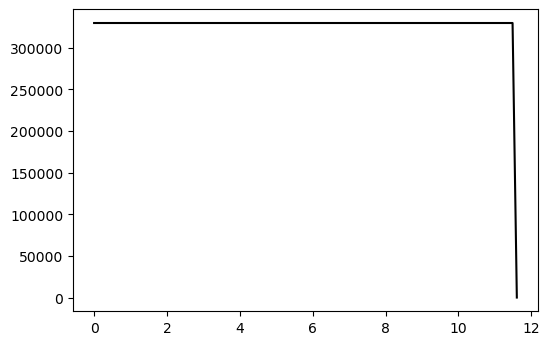

In [56]:
m.P_itr.plot()

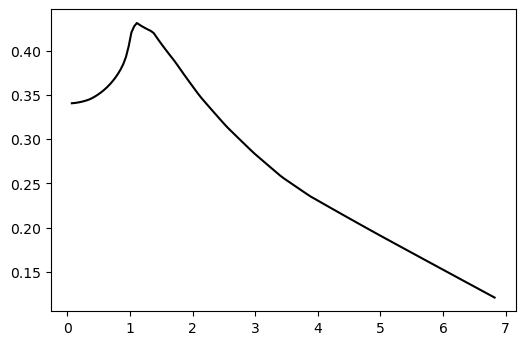

In [57]:
m.Cya_itr.plot()

In [58]:
m.set_init_cond()

In [59]:
def distance(missile, target, r_kill=opts['r_kill']):
    r = np.sqrt((target[-1]['x'] - missile[-1]['x'])**2 + (target[-1]['y'] - missile[-1]['y'])**2)
    return (True, r) if r <= r_kill else (False, r)

In [60]:
summaries_m = [m.get_summary()]
summaries_t = [t.get_summary()]
tau = 0.1
r = distance(summaries_m, summaries_t)
while r[0] == False:
    k = m.get_action_parallel_guidance(t)
    act = m.action_sample() * k
    m.step(act, tau)
    t.step(tau)
    summaries_m.append(m.get_summary())
    summaries_t.append(t.get_summary())
    r = distance(summaries_m, summaries_t)
    print(r[1])

6313.5580620697265
6301.363802604838
6287.9706718577
6273.370272775558
6257.563505894729
6240.536533741841
6222.2897152573405
6202.811635905183
6182.100150068159
6160.1437270408815
6136.957418358514
6112.576175249163
6087.009751269158
6060.264869778579
6032.330164240047
6003.13321474436
5972.630943743609
5940.822978079722
5907.732131030097
5873.321352664008
5837.57566223247
5800.527207600388
5762.232720803415
5722.65516617419
5681.909759202976
5640.038521881344
5596.90319897526
5552.436043327534
5506.748605003492
5459.967282515032
5412.053978546087
5362.816758687947
5312.17691691683
5260.1346794942765
5206.7331245305095
5151.913342015868
5095.660272555984
5037.975831015138
4978.965198603001
4918.7409690953245
4857.17416227991
4794.354569026378
4730.105354308792
4664.345152015928
4597.115811310576
4528.389398157877
4458.2216477014035
4386.541134765085
4313.50875697042
4239.491576376919
4164.595197818769
4088.484590276636
4010.9432430855045
3932.0253727731556
3852.136441951172
3771.52348

In [61]:
ts = [s['t'] for s in summaries_m]
xs_m = [s['x'] for s in summaries_m]
ys_m = [s['y'] for s in summaries_m]
xs_t = [s['x'] for s in summaries_t]
ys_t = [s['y'] for s in summaries_t]

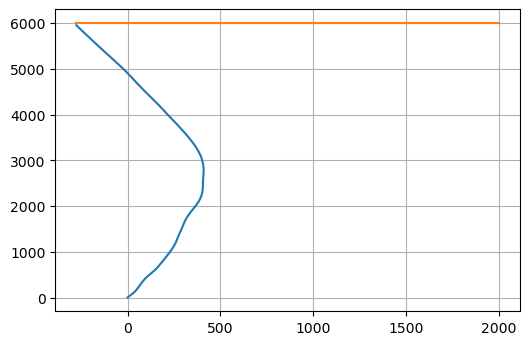

In [62]:
plt.figure(dpi=100)
plt.plot(xs_m, ys_m)
plt.plot(xs_t, ys_t)
plt.grid()
plt.show()